### CAS KAGGLE

Guia 

1- introducció / llegir base de dades
2- data cleaning / preprocessament (tractar els nans, tractar els outliers)
3- Exploration data analisiy 

#### Introducció

Per realitzar el nostre cas Kaggle hem triat el famòs dataset airbnb se la ciutat de Nova York. Aquest dataset descriu la llista d'activitats i mértiques dels airbn a la ciutat de New York al 2019. 

Es tractar un problema de regressió ja que el target serà predir el preu per nit del AirBnb.



In [49]:
#importem llibreries
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

Primer de tot llegim el dataset. I és molt important veure les dades i els atributs del nostre dataset i entrendre-les així serà més fàcil per després. 

In [50]:
df = pd.read_csv('dataset/AB_NYC_2019.csv')

print(f'El nombre de mostres son: {df.shape[0]}')
print(f"El nombre d'atributs son: {df.shape[1]}")

print(df.dtypes)

df.head



El nombre de mostres son: 48895
El nombre d'atributs son: 16
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


<bound method NDFrame.head of              id                                               name   host_id  \
0          2539                 Clean & quiet apt home by the park      2787   
1          2595                              Skylit Midtown Castle      2845   
2          3647                THE VILLAGE OF HARLEM....NEW YORK !      4632   
3          3831                    Cozy Entire Floor of Brownstone      4869   
4          5022   Entire Apt: Spacious Studio/Loft by central park      7192   
...         ...                                                ...       ...   
48890  36484665    Charming one bedroom - newly renovated rowhouse   8232441   
48891  36485057      Affordable room in Bushwick/East Williamsburg   6570630   
48892  36485431            Sunny Studio at Historical Neighborhood  23492952   
48893  36485609               43rd St. Time Square-cozy single bed  30985759   
48894  36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

         

Com podem veur el nostre dataset té 48895 mostres, és a dir files. I després té 16 atributs. El target serà l'atribut price.

#### Descripció dels atributs: 
- id: identificador 
- name: nom de l'anunci
- host_id: id del host 
- neighbourhood_group: localització
- neighbourhood: barri 
- latitude: latitud
- longitude: longitud
- room_type: tipus d'apartament 
- price: preu en dolars (target)
- number_of_reviews: número de reviews
- last_review: data de l'ultima ressenya
- calculated_host_listings_count: número de apartamentos que tiene el anfitrion
- availability_365: número de dias que está disponible para reservar 



## 1. Data Cleaning i Preprocessament 

##### Mirem si conté valors nuls

In [51]:
#numero de valores nulos en el dataset 
num_valors_null = df.isnull().sum()
percentatge_null = df.isnull().sum()/df.size

#percentatge valors nuls, per entendre millor 
print(percentatge_null)

#llistem els valors nuls
columna_null = df.columns[df.isnull().any()].to_list()
print(columna_null)


id                                0.000000
name                              0.000020
host_id                           0.000000
host_name                         0.000027
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.012849
reviews_per_month                 0.012849
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64
['name', 'host_name', 'last_review', 'reviews_per_month']


In [52]:
# número de valors nulls 
for valor in columna_null:
    print(df[valor].isnull().value_counts())

name
False    48879
True        16
Name: count, dtype: int64
host_name
False    48874
True        21
Name: count, dtype: int64
last_review
False    38843
True     10052
Name: count, dtype: int64
reviews_per_month
False    38843
True     10052
Name: count, dtype: int64


#### Remplaçament de valors nuls 

Les columnes 'name', 'host_name' tenen molt pocs nans. Per tant, la manera més fácil i sense afectar al model és eliminant les files que contenen els nans.  

Podem observar, que last_review i reviews_per_month estan connectats un amb l'altre. Els valors que falten representen que no s'ha deixat una ressenya per aquella anunci AirBnb. Basicament si no hi ha la data de ressenya tampoc estará el camp reviews_per_month (és un percentatge).
 - Les reviews_per_month replacarem els nans per una puntuació de 0.0, que indicarà que no hi ha ressenya.
 - La last_reviews_per_month per una data simbolica que sera l'última data possible '2019-12-31' 

In [53]:
#eliminem files amb nans 'name'
df.dropna(subset=['name'], inplace=True)

#eliminem files amb nans 'host_name'
df.dropna(subset=['host_name'], inplace=True)


In [54]:
#omplim reviews_per_month
df['reviews_per_month'] = df['reviews_per_month'].fillna(0.0)

#omplim last_reviews_per_month
df['last_review'] = df['last_review'].fillna("2019-12-31")

In [55]:
df.isnull().sum()/df.size

id                                0.0
name                              0.0
host_id                           0.0
host_name                         0.0
neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
last_review                       0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

Podem veure com no queda cap nan.

Anem afegir un atribut que ens servira que s'anomeni 'minim_preu_estancia', será el preu per nit per el mínim de nits. És a dir el mínim preu que pagará un client

In [56]:
df['minim_preu_estancia'] = df['price'] * df['minimum_nights']


##### Tractement de valors outlande

### 2. Exploratory Data Analysis

Text(0, 0.5, 'Nº AirBnb')

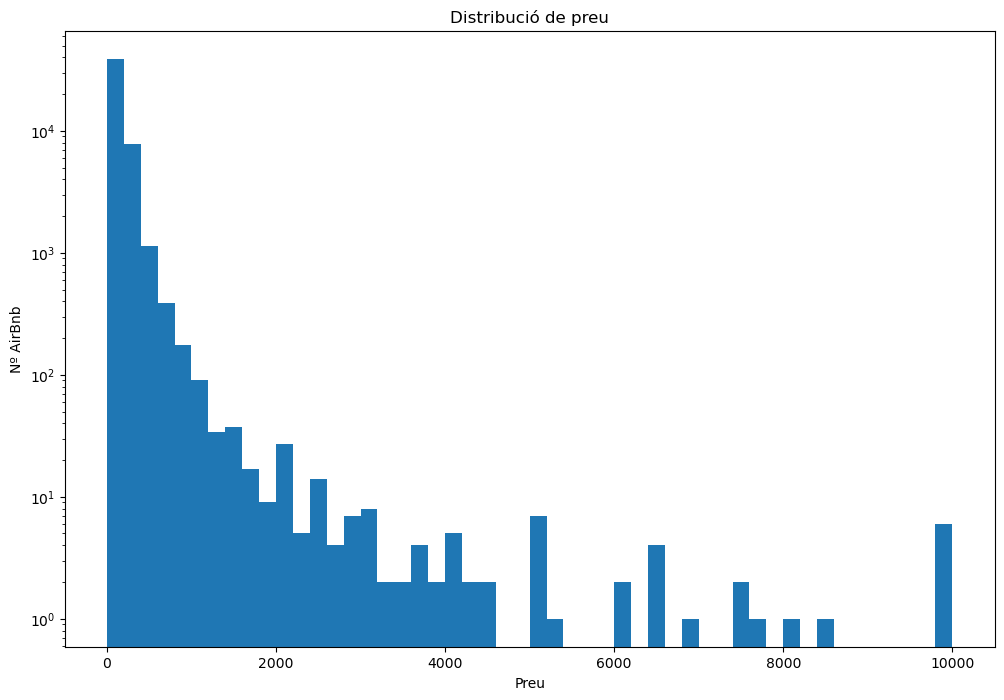

In [62]:
# Distribució del preu d'alquiler 
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(df['price'], bins=50, log=True)
ax.set_title('Distribució de preu')
ax.set_xlabel('Preu')
ax.set_ylabel('Nº AirBnb')

Anem a fer el mateix però amb el preu per estancia. 

Text(0, 0.5, 'Nº AirBnb')

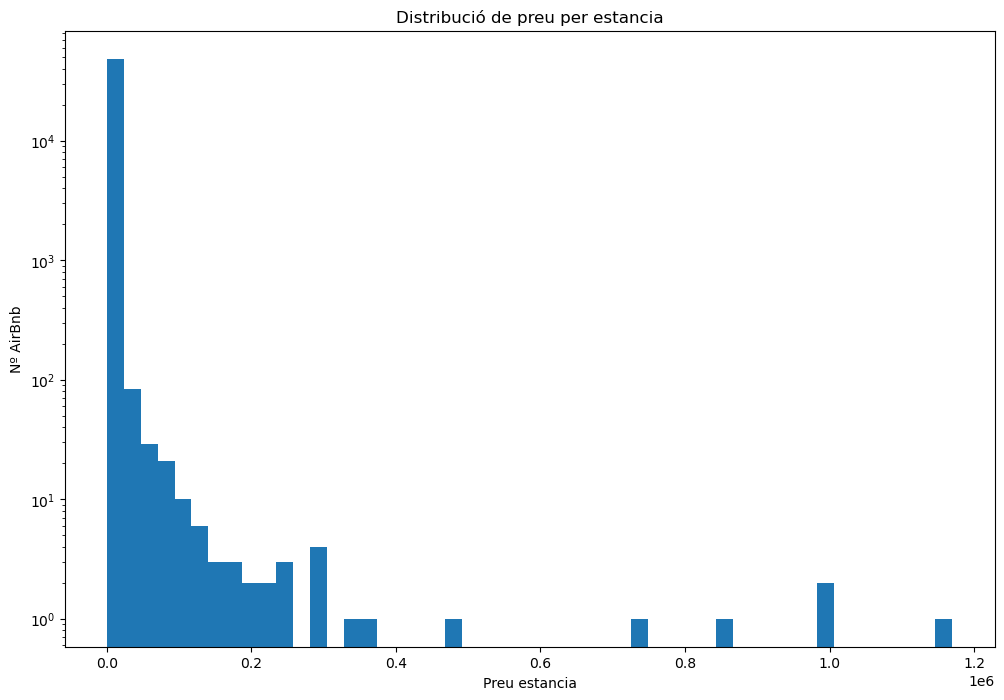

In [61]:
# Distribució del preu per estancia 
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(df['minim_preu_estancia'], bins=50, log=True)
ax.set_title('Distribució de preu per estancia')
ax.set_xlabel('Preu estancia')
ax.set_ylabel('Nº AirBnb')


C:\Users\polvi\AppData\Local\Temp\ipykernel_19872\2475219527.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='neighbourhood_group', data=df, palette=colors)


neighbourhood_group
Manhattan        21643
Brooklyn         20089
Queens            5664
Bronx             1089
Staten Island      373
Name: count, dtype: int64


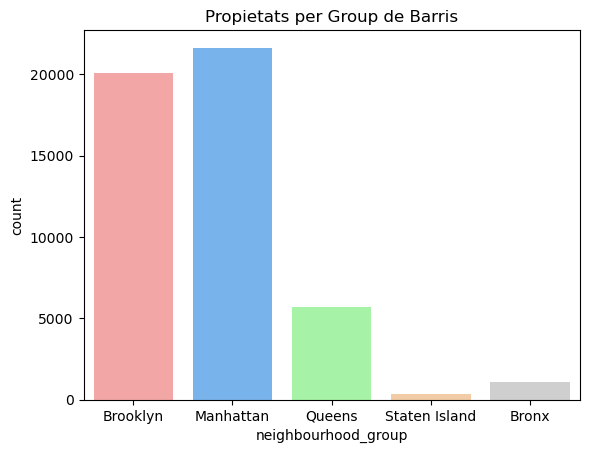

In [75]:
#anem a veure quants airBnb hi han en cada barri 
titol = 'Propietats per Group de Barris'

#fiquem colors perque visualment sigui més bonic
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#CFCFCF']

sns.countplot(x='neighbourhood_group', data=df, palette=colors)
plt.title(titol)
plt.show

print(df['neighbourhood_group'].value_counts())



In [74]:
#anem a calcular l'area dels airbnb per poder dibuixar sobre el mapa 
Rectangle_img = (df['longitude'].min(), df['longitude'].max(), df['latitude'].min(), df['latitude'].max())

nyc_img = plt.imread('dataset/New_York_City_.png')

#tamany del gràfic
fig, ax = plt.subplots(figsize=(12,8), facecolor='w') 
#delimitar gràfic
ax.scatter(df['longitude'], df['latitude'], zorder=1, alpha=0.2, c='b', s=.75)
ax.set_xlim(Rectangle_img[0], Rectangle_img[1])
ax.set_ylim(Rectangle_img[2], Rectangle_img[3])
ax.imshow(nyc_img, zorder=0, extent=Rectangle_img, aspect='equal')

SyntaxError: not a PNG file (<string>)